# Классификации рентгеновских снимков 

Данный проект является тестовым заданием от Радиокомпании Вектор

 Выполнил Фатихов Артур

## Оглавление
1. Введение
2. Обработка и визуализация данных

## 1. Введение

В данном Jupyter-notebook я создам модель для классификации изображений рентгеновских снимков, а именно разделение их на три категории:
- фронтальная проекция(front)
- боковые проекции(lateral)
- снимки, содержащие иные проекции и органы(trash)

### Контент

Датасет для создания модели состоит из 2 частей: Train и Validation

Датасет Train (находится в соответствующей папке) состоит из 4188 РГ снимков формата PNG, разбитых на подвыборки. Данный датасет предназначен для обучения классификатора.
Класс «FRONTAL» (находится в соответствующей папке) датасета Train состоит из 1399 снимков во фронтальной проекции.
Класс «LATERAL» (находится в соответствующей папке) датасета Train состоит из 1400 снимков в боковой проекции.
Класс «TRASH» (находится в соответствующей папке) датасета Train состоит из 1389 снимков, содержащих иные проекции и органы.
 

Датасет Validation состоит из 1000 РГ изображений формата PNG.
Класс «FRONTAL» (находится в соответствующей папке) датасета Validation состоит из 330 снимков во фронтальной проекции.
Класс «LATERAL» (находится в соответствующей папке) датасета Validation состоит из 330 снимков в боковой проекции.
Класс «TRASH» (находится в соответствующей папке) датасета Validation состоит из 340 снимков, содержащих иные проекции и органы.
Датасет Validation предназначен для открытой валидации классификатора, снимки из данного датасета не принимают участие в обучении.

Наша цель создать модель, которая будет предугадывать к какому из трех классов относится изображение,  пропускаемые нашу модель.
Для создания этой модели я буду использовать CNN, так как отлично работает с классификацией изображений за счет создания фильтров.

Импортируем все необходимые библиотеки

In [1]:
import os
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

    

np.random.seed(0) # чтобы 

from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix, f1_score, classification_report
from sklearn.metrics import classification_report

import seaborn as sns

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, Conv1D, MaxPool1D, Input, BatchNormalization
from tensorflow.keras.optimizers import Adam, RMSprop, Nadam
from tensorflow.keras.losses import SparseCategoricalCrossentropy, CategoricalCrossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.optimizers.experimental import RMSprop
from tensorflow.keras.regularizers import L2


physical_devices = tf.config.list_physical_devices('GPU') #Использую эту часть кода, чтобы работали ядра gpu
tf.config.experimental.set_memory_growth(physical_devices[0], True)
print(physical_devices)

2024-03-15 14:43:51.852389: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-15 14:43:51.986411: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-15 14:43:51.986455: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-15 14:43:52.003210: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-15 14:43:52.054257: I tensorflow/core/platform/cpu_feature_guar

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2024-03-15 14:43:53.335570: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-15 14:43:53.406650: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-15 14:43:53.406763: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

## 2. Обработка и визуализация данных

Создаю лейблы в виде цифр для кажого лейбла, чтобы наша модель могла работать на этой дате, помещаю все в словарь, чтобы дальше мы могли его использовать

In [2]:
labels = {'FRONTAL': 0, 'LATERAL': 1, 'TRASH': 2}

Создаю функции для создания объектов обучающих и валидационных данных

In [3]:
def load_images_from_folder(folder_path, label, img_size=512, add_id=False):
    """Эта функция создает из каждого изображения в папке которую мы передали
        numpy.array и собирает все изображения в pandas.DataFrame(имеет колонки
        label и picture) 'df' в котором каждое изображение получает лейбел из 
        переданного в функцию аргумента. Также функция имеет аргумент img_size,
        по умолчанию 512, но может быть изменена, чтобы можно было изменить размер картинки"""
    if add_id:
        df = pd.DataFrame(columns=['id', 'label', 'picture'])
    else:
        df = pd.DataFrame(columns=['label', 'picture'])
    for filename in os.listdir(folder_path): #цикл проходит по всем названиям файлов в папке
        img_path = os.path.join(folder_path, filename)
        try: #ecли какой-то файл имеет другой формат, то печатает исключение в output, а не выбрасывает его
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            img_resized = cv2.resize(img, (img_size, img_size)) #размер отличающихся изображений будет подогнан под стандарт
            if add_id:
                df.loc[len(df.index)] = [filename, label, img_resized]
            else:
                df.loc[len(df.index)] = [label, img_resized]
        except Exception as e:
            print(e)
    return  df

def create_x_y(df, add_id=False):
    """Это функция создает input(x) и output(y)
        для модели"""
    if add_id:
        y = df[['id', 'label']]
    else:
        y = df['label']
    x = [] #собирает все np.array в один
    for array in df['picture']:
        x.append(array)
    return np.array(x), np.array(y)

def extract_data(general_folder_name, labels, shuffle=True, add_id=False):
    """Эта функция собирает все датафреймы, полученные через функцию load_images_from_folder
        и соединяет их один датафрейм. Если shuffle=True функция перемешивает строки в датафрейме.
        После этого создает из датафрейма input(x) и output(y) и возвращает их."""
    if add_id:
        resulting_df = pd.DataFrame(columns=['id', 'label', 'picture'])
    else:
        resulting_df = pd.DataFrame(columns=['label', 'picture'])
    for folder_name in os.listdir(general_folder_name): #проходимся по всем названиям папок в 
        label = labels[folder_name]
        folder_path = os.path.join(general_folder_name, folder_name) # формирует полный путь к папке
        df = load_images_from_folder(folder_path, label, add_id=add_id)
        resulting_df = pd.concat([resulting_df, df])
    if shuffle:
        resulting_df = resulting_df.sample(frac=1) #перемешивает весь датасет, чтобы модель работала лучше
    x, y = create_x_y(resulting_df, add_id) # создает x, y
    return x, y

Загружаю все данные для тренинга и валидации

In [4]:
X_train, y_train = extract_data('train', labels)
X_validation, y_validation = extract_data('validation', labels, add_id=True, shuffle=False)

OpenCV(4.9.0) /io/opencv/modules/imgproc/src/resize.cpp:4152: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

OpenCV(4.9.0) /io/opencv/modules/imgproc/src/resize.cpp:4152: error: (-215:Assertion failed) !ssize.empty() in function 'resize'



Посмотрм на формы нашых данных, чтобы увидеть все ли сделано корректно

In [5]:
X_train.shape

(4187, 512, 512)

In [6]:
y_train.shape

(4187,)

In [7]:
X_validation.shape

(928, 512, 512)

In [8]:
y_validation.shape

(928, 2)

У нас 4187 кейсов в train датасете и 928 в validation

Нам нужно провести rescaling и reshaping X_train и X_validation, так как сейчас они находятся в диапазоне от 0 до 255, что будет мешать работе нашей модели. Поэтому поделим все значения на 255, чтобы изменить их диапазон в промежуток от 0 до 1. В таком случае модель будет работать быстрее и эффективнее.
Также необходимо изменить форму и добавить новую измерение, которе будет показывать канальность изображения, в нашем случае один.

In [9]:
X_train = X_train / 255
X_validation = X_validation / 255
X_train = X_train.reshape(*X_train.shape, 1)
X_validation = X_validation.reshape(*X_validation.shape, 1)
X_train = X_train.astype(np.float32)
X_validation = X_validation.astype(np.float32)

Cоздаю bar chart, чтобы мы могли взглянуть на распределение наших лейблов

<Axes: xlabel='Label', ylabel='count'>

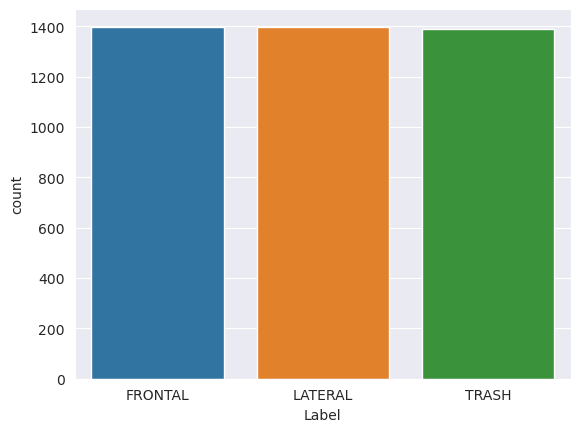

In [10]:
df = pd.DataFrame({'Label': ['FRONTAL'] * (y_train == 0).sum() + ['LATERAL'] * (y_train == 1).sum() + 
                  ['TRASH'] * (y_train == 2).sum()})
sns.set_style('darkgrid')
sns.countplot(data=df, x='Label')

Наши данные практически идеально распределена, что является редкостью для медицинской даты. Это очень хорошо для модели, так как именно такое распределение дает лучший результат будущих предсказаний 

Покажу несколько примеров из нашей даты, чтобы наглядно увидеть с какими изображениями я работаю

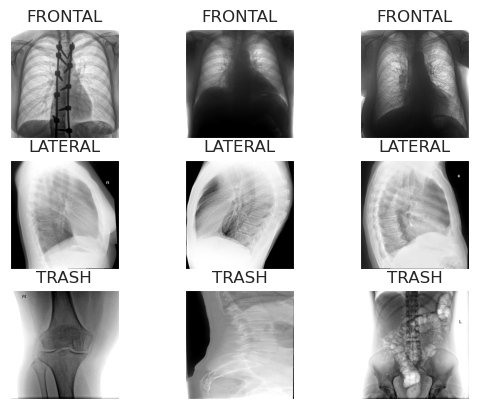

In [11]:
fig, ax = plt.subplots(3,3)
for i in range(3):
    for j in range(3):
        if i == 0:
            ax[i][j].imshow(X_train[y_train==0][j], cmap='gray')
            ax[i][j].set_title('FRONTAL')
        elif i == 1:
            ax[i][j].imshow(X_train[y_train==1][j], cmap='gray')
            ax[i][j].set_title('LATERAL')
        else:
            ax[i][j].imshow(X_train[y_train==2][j], cmap='gray')
            ax[i][j].set_title('TRASH')
        ax[i][j].set_xticks([])
        ax[i][j].set_yticks([])

Как можно видеть наши данные состоят из фронтальных, лательных рентгеновских снимков, а также из рентгеновских снимков, которые не относятся к первым двум лейблам или вовсе просто являются шумом

Нам необходимо превратить y_train и y_validation в one hot encoded, увеличить количество output в кажом случае до 3, все они будут бинарно указывать на один из лейблов

In [12]:
y_train = y_train.astype(np.int32)
y_train_tensor = tf.keras.utils.to_categorical(y_train)

In [13]:
y_validation_int = y_validation[:,1].astype(np.int32)
y_validation_tensor = tf.keras.utils.to_categorical(y_validation_int)

###  Data agumetation
Нам необходимо воспользоваться этим методом, чтобы увеличить количество наших исходных данных, чтобы наша модель лучше работала на новых данных. Я буду делать это при помощи tensorflow.keras.preprocessing.image.ImageDataGenerator. Этот инструмент предоставляет нам все необходимые инструменты для увеличния данных

In [14]:
datagen = ImageDataGenerator(
        featurewise_center=False, 
        samplewise_center=False,
        featurewise_std_normalization=False,  
        samplewise_std_normalization=False, 
        zca_whitening=False, 
        rotation_range = 30,  # рандомно поворачиваем картинки на 30 градусов
        zoom_range = 0.2, # рандомно увеличивем картинку
        width_shift_range=0.1,  # рандомно двигаем картинку горизонтально
        height_shift_range=0.1,  # рандомно двигаем картинку вертикально
        horizontal_flip = True,  # рандомно горизонтально крутим картинки
        vertical_flip=False) 


datagen.fit(X_train)

Создаю CNN модель, которая будет давать нам предсказания. Использую для этого 4 сверточных слоя и 3 польностью соединенных слоя.

In [15]:
model = Sequential([
    Conv2D(32, (2,2) , strides = 2 , padding = 'same' , activation = 'relu' , input_shape = (512,512,1)), # conv layer
    BatchNormalization(), # необходим для ускорения работы нейронной сети и для ее регуляризации
    MaxPool2D((2,2) , strides = 2), # выборочно выключет нейроны, необходим для регуляризации
    Conv2D(32, (2,2) , strides = 2 , padding = 'same' , activation = 'relu'),
    BatchNormalization(),
    MaxPool2D((2,2) , strides = 2),
    Conv2D(32, (2,2) , strides = 2 , padding = 'same' , activation = 'relu'),
    BatchNormalization(),
    MaxPool2D((2,2) , strides = 2),
    Conv2D(16, (2,2) , strides = 2 , padding = 'same' , activation = 'relu'),
    MaxPool2D((2,2) , strides = 2),
    Flatten(), # превращает input в один слой полностью соединенных данных(в 1D)
    Dense(100, activation='relu'), # полностью соединенный слой
    Dropout(0.1), 
    Dense(units = 40 , activation= 'relu'),
    Dropout(0.1),
    Dense(units = 3 , activation = 'softmax'), # выходной слой, дает нам результат модели
])

2024-03-15 14:44:14.748880: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-15 14:44:14.749001: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-15 14:44:14.749064: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [16]:
model.compile(optimizer = Adam(0.001), loss = CategoricalCrossentropy(), metrics=['accuracy'])

In [17]:
history = model.fit(datagen.flow(X_train, y_train_tensor, batch_size = 32) ,epochs = 130)

Epoch 1/130


2024-03-15 14:44:26.062240: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-03-15 14:44:26.154713: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-03-15 14:44:26.587980: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-03-15 14:44:26.898451: I external/local_xla/xla/service/service.cc:168] XLA service 0x7fa81477eed0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-03-15 14:44:26.898468: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2024-03-15 14:44:26.904380: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1710503066.949901   17922 device_compiler.

131/131 [==============================] - 26s 174ms/step - loss: 0.6273 - accuracy: 0.7358
Epoch 2/130
131/131 [==============================] - 23s 175ms/step - loss: 0.3196 - accuracy: 0.8777
Epoch 3/130
131/131 [==============================] - 23s 179ms/step - loss: 0.2291 - accuracy: 0.9164
Epoch 4/130
131/131 [==============================] - 23s 177ms/step - loss: 0.2039 - accuracy: 0.9252
Epoch 5/130
131/131 [==============================] - 23s 178ms/step - loss: 0.1992 - accuracy: 0.9322
Epoch 6/130
131/131 [==============================] - 23s 173ms/step - loss: 0.1616 - accuracy: 0.9439
Epoch 7/130
131/131 [==============================] - 23s 172ms/step - loss: 0.1455 - accuracy: 0.9527
Epoch 8/130
131/131 [==============================] - 23s 173ms/step - loss: 0.1438 - accuracy: 0.9496
Epoch 9/130
131/131 [==============================] - 22s 170ms/step - loss: 0.1444 - accuracy: 0.9496
Epoch 10/130
131/131 [==============================] - 24s 181ms/step - los

131/131 [==============================] - 23s 176ms/step - loss: 0.0463 - accuracy: 0.9845
Epoch 80/130
131/131 [==============================] - 23s 174ms/step - loss: 0.0451 - accuracy: 0.9866
Epoch 81/130
131/131 [==============================] - 23s 178ms/step - loss: 0.0420 - accuracy: 0.9845
Epoch 82/130
131/131 [==============================] - 23s 178ms/step - loss: 0.0405 - accuracy: 0.9861
Epoch 83/130
131/131 [==============================] - 24s 180ms/step - loss: 0.0357 - accuracy: 0.9878
Epoch 84/130
131/131 [==============================] - 23s 176ms/step - loss: 0.0352 - accuracy: 0.9873
Epoch 85/130
131/131 [==============================] - 23s 178ms/step - loss: 0.0484 - accuracy: 0.9847
Epoch 86/130
131/131 [==============================] - 23s 175ms/step - loss: 0.0553 - accuracy: 0.9814
Epoch 87/130
131/131 [==============================] - 23s 176ms/step - loss: 0.0347 - accuracy: 0.9883
Epoch 88/130
131/131 [==============================] - 26s 196ms/st

## 4.  Интерпритация результатов

In [29]:
print("Accuracy of the model in trainig dataset - " , model.evaluate(X_train,y_train_tensor)[1]*100 , "%")
# Точность модели на train дате

2024-03-15 14:08:34.159423: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-03-15 14:08:34.248085: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


 16/131 [==>...........................] - ETA: 1s - loss: 1.0986 - accuracy: 0.3105

2024-03-15 14:08:34.658492: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


131/131 [==============================] - 2s 13ms/step - loss: 1.0981 - accuracy: 0.3227
Accuracy of the model in trainig dataset -  32.266539335250854 %


In [18]:
loss, accuracy = model.evaluate(X_validation, y_validation_tensor)

print(f"Accuracy of the model on the training dataset: {accuracy * 100}%")
# Точность модели на validation дате

29/29 [==============================] - 0s 9ms/step - loss: 0.4360 - accuracy: 0.9547
Accuracy of the model on the training dataset: 95.4741358757019%


Я получил точность модели 95.5 %, это хороший результат, но также дальнешее улучшение модели и увеличение тренировочных данных может помочь снизить variance и получить большую точность на валидативных данных

Высчитаю recall, presision, f1 score, построю confusion matrix, чтобы можно было лучше интерпретировать наши результаты

In [20]:
y_validation[:,1] = y_validation[:,1].astype(np.int32) # перевожу лейблы в int32

29/29 [==============================] - 0s 9ms/step
              precision    recall  f1-score   support

     FRONTAL       1.00      0.85      0.92       259
     LATERAL       0.89      1.00      0.94       329
       TRASH       1.00      0.99      0.99       340

    accuracy                           0.95       928
   macro avg       0.96      0.95      0.95       928
weighted avg       0.96      0.95      0.95       928



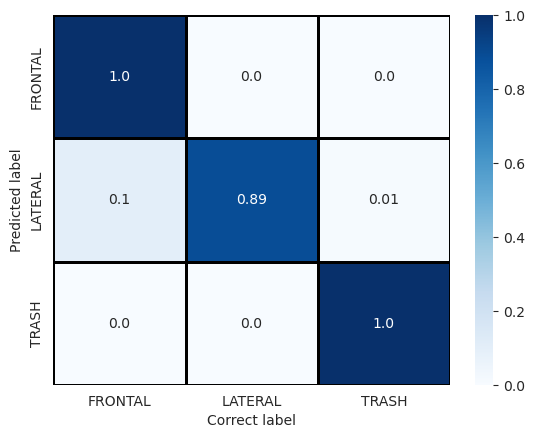

In [27]:
y_pred = model.predict(X_validation)
y_pred_encoded = np.argmax(y_pred, axis=1)
conf = confusion_matrix(y_pred_encoded, y_validation_int)
conf_sum = conf.sum(axis=1, keepdims=True)
sns.heatmap(np.round(conf/conf_sum, 2),cmap= "Blues", linecolor = 'black' , linewidth = 1 ,
            annot = True, fmt='',xticklabels = labels.keys(),
            yticklabels = labels.keys())
plt.xlabel('Correct label')
plt.ylabel('Predicted label')
print(classification_report(y_validation_int, y_pred_encoded, target_names=labels.keys()))

F1 score составляет 95%. Это хороший результат, который свидетельствует о высокой эффективности  модели.

Наглядно посмотрим какие данные наша модель нашла неверно

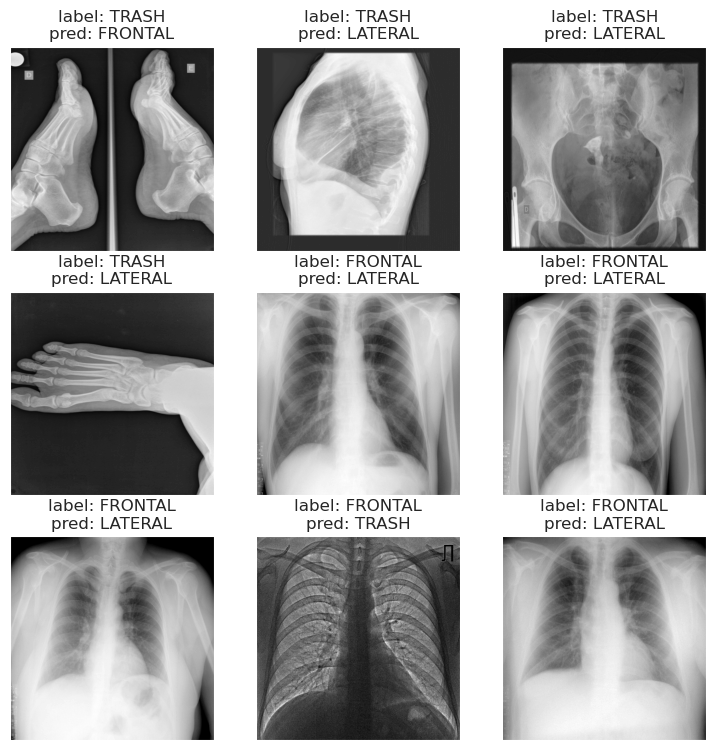

In [23]:
labels_reversed = {0:'FRONTAL', 1:'LATERAL', 2:'TRASH'}
wrongs = X_validation[y_pred_encoded != y_validation_int][:9]
fig, ax = plt.subplots(3,3, figsize=(9,9))
for i in range(3):
    for j in range(3):
        true_label = labels_reversed[y_validation_int[y_pred_encoded != y_validation_int][i * 3 + j]]
        pred_value = labels_reversed[y_pred_encoded[y_pred_encoded != y_validation_int][i * 3 + j]]
        if i == 0:
            ax[i][j].imshow(wrongs[i * 3 + j], cmap='gray')
            ax[i][j].set_title(f'label: {true_label}\npred: {pred_value}')
        elif i == 1:
            ax[i][j].imshow(wrongs[i * 3 + j], cmap='gray')
            ax[i][j].set_title(f'label: {true_label}\npred: {pred_value}')
        else:
            ax[i][j].imshow(wrongs[i * 3 + j], cmap='gray')
            ax[i][j].set_title(f'label: {true_label}\npred: {pred_value}')
        ax[i][j].set_xticks([])
        ax[i][j].set_yticks([])

Сохраняю веса модели, чтобы в дальнейшем их можно было использовать

In [19]:
model.save_weights('weights_of_the_model')

Создаю csv файл, где первая колонка это id картинки, последующие 3 это one hot encoding трех возможных значений: frontal, lateral, trash

Создаю csv файл и сохраняю результаты в виде 4 колонок 'id','frontal', 'lateral', 'trash', так как этого требует задание.

In [24]:
y_pred_one_hot = np.eye(y_pred.shape[1])[np.argmax(y_pred, axis=1)] #перевожу p_pred в one hot encoding где каждый лейбл будет иметь значение 0 или 1

In [28]:
results = pd.DataFrame(np.hstack([y_validation[:,0].reshape(-1,1), y_pred_one_hot]),
                       columns=['image_id','frontal', 'lateral', 'trash'])

In [29]:
results.to_csv('results.csv')

Результат из значений активации, выданных моделью без нахождения правильного ответа.

In [30]:
results_unchanged = pd.DataFrame(np.hstack([y_validation[:,0].reshape(-1,1), y_pred]),
                       columns=['image_id','frontal', 'lateral', 'trash'])

In [31]:
results_unchanged.to_csv('results_unchanged.csv')

Моя модель, сделанная на основе CNN показала хороший результат(точность 95.5% на тестовых данных). Если у вас остались вопросы по тестовому заданию можете задать их мне в телеграме @arturfatikhov или можете позвонить по номеру телефона +7 987 028 6589

# Спасибо за просмотр моего тестового задания. Надеюсь вам все понравилось!